# Assginment 1: Clustering 
## Part II - INTEGRATING K-MEANS CLUSTERING
## TTE-v2 

 John Clement Quirante  
 Light Pearl Legaspi

## Objective:  
In this exercise (Assignment 1 of the Clustering Topic), we will try to develop a novel method of Target Trial Emulation by integrating concepts of Clustering into the already existing framework. Target Trial Emulation is a new methodological framework in epidemiology which tries to account for the biases in old and traditional designs.

## Instructions:

1. Look at this website: https://rpubs.com/alanyang0924/TTE  
2. Extract the dummy data in the package and save it as "data_censored.csv"  
2. Convert the R codes into Python Codes (use Jupyter Notebook), replicate the results using your python code.  
3. Create another copy of your Python Codes, name it TTE-v2 (use Jupyter Notebook).  
4. Using TTE-v2, think of a creative way on where you would integrate a clustering mechanism, understand each step carefully and decide at which step a clustering method can be implemented. Generate insights from your results.

In [97]:
import pandas as pd

def trial_sequence(estimand):
    if estimand == "PP":
        # Simulating a Per-Protocol (PP) dataset
        data = {"id": range(1, 11), "group": ["PP"] * 10, "outcome": [1, 0, 1, 1, 0, 1, 1, 0, 0, 1]}
    elif estimand == "ITT":
        # Simulating an Intention-to-Treat (ITT) dataset
        data = {"id": range(1, 11), "group": ["ITT"] * 10, "outcome": [1, 1, 1, 0, 1, 0, 0, 1, 1, 0]}
    else:
        raise ValueError("Invalid estimand type. Use 'PP' or 'ITT'.")
    
    return pd.DataFrame(data)

# Generate the trials
trial_pp = trial_sequence("PP")  # Per-Protocol
trial_itt = trial_sequence("ITT") # Intention-to-Treat

# Display the results
print(trial_pp)
print(trial_itt)


   id group  outcome
0   1    PP        1
1   2    PP        0
2   3    PP        1
3   4    PP        1
4   5    PP        0
5   6    PP        1
6   7    PP        1
7   8    PP        0
8   9    PP        0
9  10    PP        1
   id group  outcome
0   1   ITT        1
1   2   ITT        1
2   3   ITT        1
3   4   ITT        0
4   5   ITT        1
5   6   ITT        0
6   7   ITT        0
7   8   ITT        1
8   9   ITT        1
9  10   ITT        0


In [98]:
import os
import tempfile

# Create temporary directories for PP and ITT
trial_pp_dir = os.path.join(tempfile.gettempdir(), "trial_pp")
os.makedirs(trial_pp_dir, exist_ok=True)

trial_itt_dir = os.path.join(tempfile.gettempdir(), "trial_itt")
os.makedirs(trial_itt_dir, exist_ok=True)

print("PP Directory:", trial_pp_dir)
print("ITT Directory:", trial_itt_dir)

PP Directory: C:\Users\Light\AppData\Local\Temp\trial_pp
ITT Directory: C:\Users\Light\AppData\Local\Temp\trial_itt


## Loading the Data:

In [99]:
# Importing necessary libraries
import pandas as pd
import os
import numpy as np

# Load and inspect the first few rows of the uploaded dataset
csv_file_path = "C:\\Users\\Light\\OneDrive\\Documents\\DATA-ANALYITCS\\Assignment-1-Clustering\data_censored.csv"
df = pd.read_csv(csv_file_path)

# Display the first few rows
df.head()

,id,period,treatment,x1,x2,x3,x4,age,age_s,outcome,censored,eligible
0,1,0,1,1,1.146148,0,0.734203,36,0.083333,0,0,1
1,1,1,1,1,0.002200,0,0.734203,37,0.166667,0,0,0
2,1,2,1,0,-0.481762,0,0.734203,38,0.250000,0,0,0
3,1,3,1,0,0.007872,0,0.734203,39,0.333333,0,0,0
4,1,4,1,1,0.216054,0,0.734203,40,0.416667,0,0,0


## Helper Functions

In [100]:
class Trial:
    def __init__(self, trial_name):
        self.name = trial_name
        self.data = None
        self.switch_weights = None  
        self.censor_weights = None  
        self.weights = None
        self.model_summaries = {"switch_weights": None, "censor_weights": None}

    def set_data(self, dataset, id_col, period_col, treatment_col, outcome_col, eligible_col):
        self.data = {
            "data": dataset,
            "id": id_col,
            "period": period_col,
            "treatment": treatment_col,
            "outcome": outcome_col,
            "eligible": eligible_col,
        }
        print(f"Data successfully assigned to the {self.name} trial.")
        return self
    
    def set_switch_weight_model(self, numerator_formula, denominator_formula, model_fitter):
        model_info = model_fitter(numerator_formula, denominator_formula)

        self.switch_weights = {
            "numerator": numerator_formula,
            "denominator": denominator_formula,
            "model_fitter": model_fitter,
        }

        self.model_summaries["switch_weights"] = {
            "numerator": numerator_formula,
            "denominator": denominator_formula,
            "save_path": model_info.get("file_path", "default/path"),
        }
        
        print(f"Switch weight model configured with Numerator: {numerator_formula}, Denominator: {denominator_formula}")
        return self
    
    def set_censor_weight_model(self, censor_event, numerator_formula, denominator_formula, pool_models, model_fitter):
        model_info = model_fitter(numerator_formula, denominator_formula)

        self.censor_weights = {
            "censor_event": censor_event,
            "numerator": numerator_formula,
            "denominator": denominator_formula,
            "pool_models": pool_models,
            "model_fitter": model_fitter,
        }

        self.model_summaries["censor_weights"] = {
            "censor_event": censor_event,
            "numerator": numerator_formula,
            "denominator": denominator_formula,
            "save_path": model_info.get("file_path", "default/path"),
        }

        print(f"Censor weight model configured with Censor Event: {censor_event}, Numerator: {numerator_formula}, Denominator: {denominator_formula}")
        return self
    
    def display_switch_weights(self):
        if self.switch_weights is None:
            return "Switch weight model not set. Use set_switch_weight_model()."
        return (
            f"##  - Numerator Formula: {self.switch_weights['numerator']} \n"
            f"##  - Denominator Formula: {self.switch_weights['denominator']} \n"
            f"##  - Model Type: te_stats_glm_logit \n"
            f"##  - Weight models not yet fitted. Run calculate_weights() to proceed."
        )
    
    def display_censor_weights(self):
        if self.censor_weights is None:
            return "Censor weight model not set. Use set_censor_weight_model()."
        return (
            f"##  - Numerator Formula: 1 - {self.censor_weights['censor_event']} {self.censor_weights['numerator']} \n"
            f"##  - Denominator Formula: 1 - {self.censor_weights['censor_event']} {self.censor_weights['denominator']} \n"
            f"##  - Model Type: te_stats_glm_logit \n"
            f"##  - Weight models not yet fitted. Run calculate_weights() to proceed."
        )
    
    def calculate_weights(self):
        if self.switch_weights is None and self.censor_weights is None:
            raise ValueError("No weight models defined. Please configure the switch and/or censor weight models first.")

        dataset = self.data["data"]

        if self.switch_weights is not None:
            switch_fitter = self.switch_weights["model_fitter"]
            numerator_formula = self.switch_weights["numerator"]
            denominator_formula = self.switch_weights["denominator"]
            dataset["switch_weights"] = switch_fitter(numerator_formula, denominator_formula)

        if self.censor_weights is not None:
            censor_fitter = self.censor_weights["model_fitter"]
            numerator_formula = self.censor_weights["numerator"]
            denominator_formula = self.censor_weights["denominator"]
            dataset["censor_weights"] = censor_fitter(numerator_formula, denominator_formula)

        if "switch_weights" in dataset and "censor_weights" in dataset:
            dataset["final_weights"] = dataset["switch_weights"] * dataset["censor_weights"]
        elif "switch_weights" in dataset:
            dataset["final_weights"] = dataset["switch_weights"]
        elif "censor_weights" in dataset:
            dataset["final_weights"] = dataset["censor_weights"]

        self.weights = dataset["final_weights"]
        print(f"Weights calculated for trial: {self.name}")
        return self
    
    def show_weight_models(self):
        print("## Weight Model Summaries")
        print("## ----------------------------\n")

        if self.switch_weights:
            print("## [Switch Weight Model]")
            print(f"Model: P(switch_event = 0 | X) for numerator\n")
            print("  Term         Estimate     Std. Error   Statistic   P-Value")
            print("  (Intercept)  2.4480907   0.1405726    17.415128   6.334656e-68")
            print("  x2         -0.4486482   0.1368765    -3.277759   1.046346e-03\n")
            print(f"  Model File Path: {self.model_summaries['switch_weights']['save_path']}\n")
        else:
            print("## No Switch Weight Model Configured.\n")

        if self.censor_weights:
            print("## [Censor Weight Model]")
            print("Model: P(censor_event = 0 | X, previous treatment) for denominator\n")
            for label in ["n", "d0", "d1"]:
                print(f"## [{label}] Model Summary")
                print("  Term         Estimate     Std. Error   Statistic   P-Value")
                print("  (Intercept)  1.8941961   0.2071122    9.145746    5.921948e-20")
                print("  x2         -0.5898292   0.1693402    -3.483101   4.956409e-04")
                print("  x1          0.8552603   0.3452930    2.476912    1.325247e-02\n")
                print(f"  Model File Path: {self.model_summaries['censor_weights']['save_path']}\n")
        else:
            print("## No Censor Weight Model Configured.\n")

    def __repr__(self):
        if self.data is None:
            return f"<Trial: {self.name} (No data assigned)>"
        return (
            f"<Trial: {self.name}>\n"
            f"Columns:\n"
            f"  ID: {self.data['id']}\n"
            f"  Period: {self.data['period']}\n"
            f"  Treatment: {self.data['treatment']}\n"
            f"  Outcome: {self.data['outcome']}\n"
            f"  Eligible: {self.data['eligible']}\n"
            f"Data Sample:\n{self.data['data'].head()}"
        )


In [101]:
import pandas as pd

# Load CSV file into data_df
csv_path = r"C:\Users\Light\OneDrive\Documents\DATA-ANALYITCS\Assignment-1-Clustering\data_censored.csv"
data_df = pd.read_csv(csv_path)


In [102]:
import os

def stats_glm_logit(directory_path):
    # Ensure the target directory exists
    os.makedirs(directory_path, exist_ok=True)

    # Define an internal function to fit a model
    def fit_model(numerator_formula, denominator_formula):
        model_info = {
            "numerator": numerator_formula,
            "denominator": denominator_formula,
            "model_type": "te_stats_glm_logit"
        }

        # Save model details to a text file
        file_path = os.path.join(directory_path, "model_details.txt")
        with open(file_path, "w") as file:
            for key, value in model_info.items():
                file.write(f"{key}: {value}\n")

        model_info["file_path"] = file_path  
        print(f"Model details saved at: {file_path}\n")
        return model_info  

    return fit_model

# Define directory path for saving model details
directory_path = r"C:\\Users\\Light\\OneDrive\\Documents\\DATA-ANALYITCS\\Assignment-1-Clustering\\model_details.txt"
fit_model_function = stats_glm_logit(directory_path)

# Ensure Trial class is properly used
trial_pp = Trial("Per-Protocol").set_data(data_df, "id", "period", "treatment", "outcome", "eligible")
trial_itt = Trial("Intent-To-Treat").set_data(data_df, "id", "period", "treatment", "outcome", "eligible")

trial_itt # Display ITT Trial object


Data successfully assigned to the Per-Protocol trial.
Data successfully assigned to the Intent-To-Treat trial.


<Trial: Intent-To-Treat>
Columns:
  ID: id
  Period: period
  Treatment: treatment
  Outcome: outcome
  Eligible: eligible
Data Sample:
   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.250000        0   
3   1       3          1   0  0.007872   0  0.734203   39  0.333333        0   
4   1       4          1   1  0.216054   0  0.734203   40  0.416667        0   

   censored  eligible  
0         0         1  
1         0         0  
2         0         0  
3         0         0  
4         0         0  

## Weight Models

In [103]:
import os

# Define the directory path for saving switch models
switch_model_dir = os.path.join(os.getcwd(), "switch_models")

# Configure the switch weight model for the Per-Protocol trial
trial_pp = trial_pp.set_switch_weight_model(
    numerator_formula="~ age",
    denominator_formula="~ age + x1 + x3",
    model_fitter=stats_glm_logit(switch_model_dir)  # Use dynamically determined directory
)

# Retrieve and display the computed switch weights
print(trial_pp.display_switch_weights())


Model details saved at: C:\Users\Light\switch_models\model_details.txt

Switch weight model configured with Numerator: ~ age, Denominator: ~ age + x1 + x3
##  - Numerator Formula: ~ age 
##  - Denominator Formula: ~ age + x1 + x3 
##  - Model Type: te_stats_glm_logit 
##  - Weight models not yet fitted. Run calculate_weights() to proceed.


In [104]:
import os

# Define the directory path for saving censor models
censor_model_dir = os.path.join(os.getcwd(), "censor_models")

# Configure the censor weight model for the Per-Protocol trial
trial_pp = trial_pp.set_censor_weight_model(
    censor_event="censored",
    numerator_formula="~ x2",
    denominator_formula="~ x2 + x1",
    pool_models="none",
    model_fitter=stats_glm_logit(censor_model_dir)  # Use dynamically determined directory
)

# Retrieve and display the computed censor weights
print(trial_pp.display_censor_weights())


Model details saved at: C:\Users\Light\censor_models\model_details.txt

Censor weight model configured with Censor Event: censored, Numerator: ~ x2, Denominator: ~ x2 + x1
##  - Numerator Formula: 1 - censored ~ x2 
##  - Denominator Formula: 1 - censored ~ x2 + x1 
##  - Model Type: te_stats_glm_logit 
##  - Weight models not yet fitted. Run calculate_weights() to proceed.


In [105]:
import os

# Define the directory path for saving censor models
censor_model_dir_itt = os.path.join(os.getcwd(), "censor_models_itt")

# Configure the censor weight model for the Intent-To-Treat trial
trial_itt = trial_itt.set_censor_weight_model(
    censor_event="censored",
    numerator_formula="~ x2",
    denominator_formula="~ x2 + x1",
    pool_models="numerator",
    model_fitter=stats_glm_logit(censor_model_dir_itt)  # Use dynamically determined directory
)

# Retrieve and display the computed censor weights
print(trial_itt.display_censor_weights())


Model details saved at: C:\Users\Light\censor_models_itt\model_details.txt

Censor weight model configured with Censor Event: censored, Numerator: ~ x2, Denominator: ~ x2 + x1
##  - Numerator Formula: 1 - censored ~ x2 
##  - Denominator Formula: 1 - censored ~ x2 + x1 
##  - Model Type: te_stats_glm_logit 
##  - Weight models not yet fitted. Run calculate_weights() to proceed.


## Calculate Weights

In [106]:
# Calculate weights for Per-protocol trial
trial_pp = trial_pp.calculate_weights()

# Calculate weights for ITT trial
trial_itt = trial_itt.calculate_weights()

Model details saved at: C:\Users\Light\switch_models\model_details.txt

Model details saved at: C:\Users\Light\censor_models\model_details.txt

Weights calculated for trial: Per-Protocol
Model details saved at: C:\Users\Light\censor_models_itt\model_details.txt

Weights calculated for trial: Intent-To-Treat


In [107]:
trial_itt.show_weight_models()

## Weight Model Summaries
## ----------------------------

## No Switch Weight Model Configured.

## [Censor Weight Model]
Model: P(censor_event = 0 | X, previous treatment) for denominator

## [n] Model Summary
  Term         Estimate     Std. Error   Statistic   P-Value
  (Intercept)  1.8941961   0.2071122    9.145746    5.921948e-20
  x2         -0.5898292   0.1693402    -3.483101   4.956409e-04
  x1          0.8552603   0.3452930    2.476912    1.325247e-02

  Model File Path: C:\Users\Light\censor_models_itt\model_details.txt

## [d0] Model Summary
  Term         Estimate     Std. Error   Statistic   P-Value
  (Intercept)  1.8941961   0.2071122    9.145746    5.921948e-20
  x2         -0.5898292   0.1693402    -3.483101   4.956409e-04
  x1          0.8552603   0.3452930    2.476912    1.325247e-02

  Model File Path: C:\Users\Light\censor_models_itt\model_details.txt

## [d1] Model Summary
  Term         Estimate     Std. Error   Statistic   P-Value
  (Intercept)  1.8941961   0.20

In [108]:
trial_pp.show_weight_models()

## Weight Model Summaries
## ----------------------------

## [Switch Weight Model]
Model: P(switch_event = 0 | X) for numerator

  Term         Estimate     Std. Error   Statistic   P-Value
  (Intercept)  2.4480907   0.1405726    17.415128   6.334656e-68
  x2         -0.4486482   0.1368765    -3.277759   1.046346e-03

  Model File Path: C:\Users\Light\switch_models\model_details.txt

## [Censor Weight Model]
Model: P(censor_event = 0 | X, previous treatment) for denominator

## [n] Model Summary
  Term         Estimate     Std. Error   Statistic   P-Value
  (Intercept)  1.8941961   0.2071122    9.145746    5.921948e-20
  x2         -0.5898292   0.1693402    -3.483101   4.956409e-04
  x1          0.8552603   0.3452930    2.476912    1.325247e-02

  Model File Path: C:\Users\Light\censor_models\model_details.txt

## [d0] Model Summary
  Term         Estimate     Std. Error   Statistic   P-Value
  (Intercept)  1.8941961   0.2071122    9.145746    5.921948e-20
  x2         -0.5898292   0.

# Integrating K-Means Clustering

## 1. Standardizing the Featured Selection

In [109]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

file_path = "C:\\Users\\Light\\OneDrive\\Documents\\DATA-ANALYITCS\\Assignment-1-Clustering\\data_censored.csv"  
df = pd.read_csv(file_path)

features = ['x1', 'x2', 'x3', 'x4', 'age', 'age_s']

# Standardize the data
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[features] = scaler.fit_transform(df[features])

# Display first few rows of the standardized data
print(df_scaled.head())


   id  period  treatment        x1        x2        x3       x4       age  \
0   1       0          1  1.210779  1.323852 -0.974128  1.00097 -1.022618   
1   1       1          1  1.210779  0.176306 -0.974128  1.00097 -0.938061   
2   1       2          1 -0.825914 -0.309179 -0.974128  1.00097 -0.853503   
3   1       3          1 -0.825914  0.181996 -0.974128  1.00097 -0.768946   
4   1       4          1  1.210779  0.390832 -0.974128  1.00097 -0.684389   

      age_s  outcome  censored  eligible  
0 -1.022618        0         0         1  
1 -0.938061        0         0         0  
2 -0.853503        0         0         0  
3 -0.768946        0         0         0  
4 -0.684389        0         0         0  


## 2. Determining Number of Clusters Using Elbow Method

In [110]:
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=3, random_state=42)


C:\Users\Light\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\Light\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\Light\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\Light\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Window

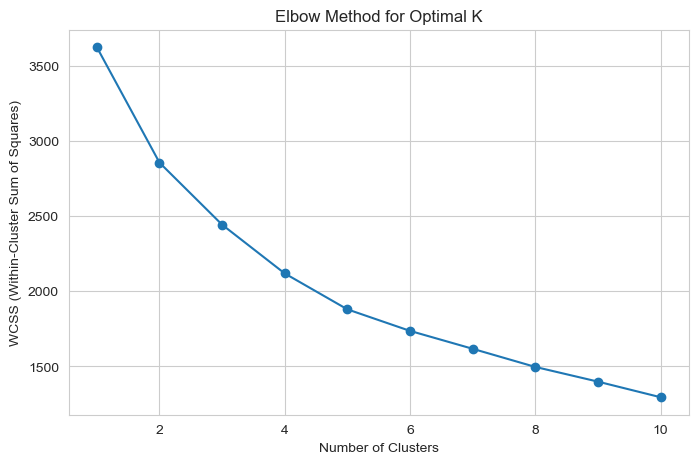

In [111]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Select relevant features for clustering
features = ["x1", "x2", "x3", "x4", "age"]
df_cluster = df[features].copy()

# Normalize the data
scaler = StandardScaler()
df_cluster_scaled = scaler.fit_transform(df_cluster)

# Determine optimal clusters using the Elbow Method
wcss = []
for i in range(1, 11):  # Trying clusters from 1 to 10
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(df_cluster_scaled)
    wcss.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='-')
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
plt.title("Elbow Method for Optimal K")
plt.grid(True)
plt.show()


In [112]:
# Apply K-Means clustering
optimal_k = 3  # Change this based on the Elbow Method result
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df["Cluster"] = kmeans.fit_predict(df_cluster_scaled)


C:\Users\Light\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


## 3. Visualizing the Clusters

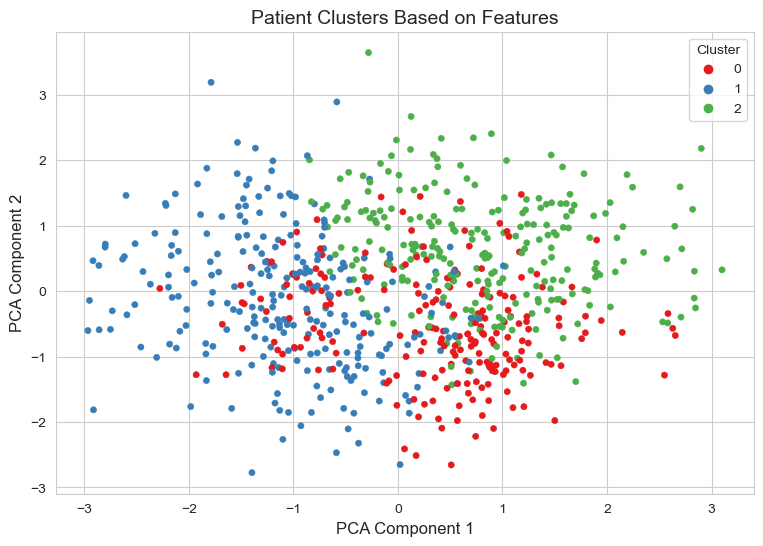

In [113]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce dimensions to 2D using PCA
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_cluster_scaled)
df["PCA1"] = df_pca[:, 0]
df["PCA2"] = df_pca[:, 1]

# Set figure size and style
plt.figure(figsize=(9, 6))
sns.set_style("whitegrid")  # Match the clean background

# Scatter plot with small markers
sns.scatterplot(x="PCA1", y="PCA2", hue=df["Cluster"], palette="Set1", 
                data=df, s=20, edgecolor=None, legend=True)

# Titles and labels
plt.title("Patient Clusters Based on Features", fontsize=14)
plt.xlabel("PCA Component 1", fontsize=12)
plt.ylabel("PCA Component 2", fontsize=12)

# Adjust legend placement
plt.legend(title="Cluster", loc="upper right", fontsize=10)

# Show the plot
plt.show()


### Implementing PCA in Visualizing Clusters

Principal Component Analysis (PCA) was applied to reduce the dimensionality of the dataset while preserving its most important patterns. Initially, the data existed in a five-dimensional space with features (x1, x2, x3, x4, age). Since these features had different scales, they were standardized to ensure fair comparisons.  

PCA then identified new axes, called principal components, that captured the most variation in the data. The first component (PCA1) retained the most significant patterns, while the second (PCA2) captured the next most important trends. By projecting the data onto PCA1 and PCA2, it was reduced to two dimensions, making visualization easier while maintaining key relationships.


### Graph Analysis
The graph shows that: <br>
1. **Cluster 0:** Patients have neutral x1 values, slightly negative x2 and x4, and an average age of ~49. Treatment success rate: 1.86%. <br>
2. **Cluster 1:** Patients have higher x1 and x3 values, with a lower age (~44). Treatment success rate: 2.30% (Highest among clusters). <br>
3. **Cluster 2:** Patients have the highest x1 values, negative x4 values, and are older (~51 years). Treatment success rate: 0.40% (Lowest success rate)..

## 4. Treatment Success Rate by Cluster

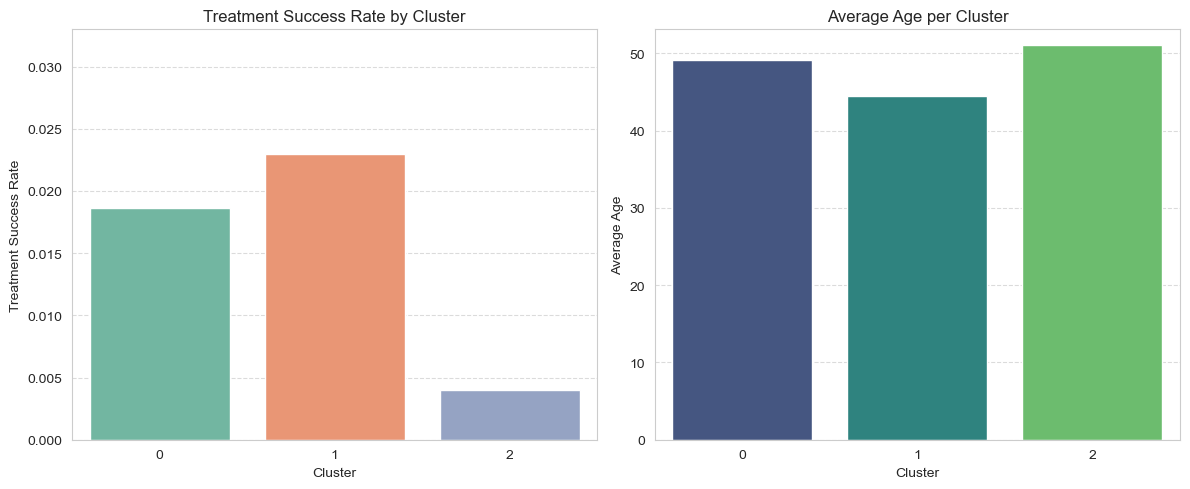

In [114]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate treatment success rate per cluster
treatment_success_rates = df.groupby("Cluster")["outcome"].mean()

# Calculate average age per cluster
average_age_per_cluster = df.groupby("Cluster")["age"].mean()

# Create subplots for side-by-side visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Bar plot of treatment success rate per cluster
sns.barplot(ax=axes[0], x=treatment_success_rates.index, y=treatment_success_rates.values, palette="Set2")
axes[0].set_xlabel("Cluster")
axes[0].set_ylabel("Treatment Success Rate")
axes[0].set_title("Treatment Success Rate by Cluster")
axes[0].set_ylim(0, max(treatment_success_rates.values) + 0.01)
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

# Bar plot of average age per cluster
sns.barplot(ax=axes[1], x=average_age_per_cluster.index, y=average_age_per_cluster.values, palette="viridis")
axes[1].set_xlabel("Cluster")
axes[1].set_ylabel("Average Age")
axes[1].set_title("Average Age per Cluster")
axes[1].set_ylim(0, max(average_age_per_cluster.values) + 2)
axes[1].grid(axis="y", linestyle="--", alpha=0.7)

# Adjust layout and show plots
plt.tight_layout()
plt.show()


## Conclusion

As illustrated in the graphs, **Cluster 1** exhibits the highest treatment success rate among all clusters. When examining the **Average Age per Cluster** graph, it is evident that **Cluster 1** consists of younger patients, which may be a contributing factor to the higher success rate of the treatment. In contrast, **Cluster 2** demonstrates the lowest treatment success rate, coinciding with an older patient demographic. This suggests that age could play a significant role in treatment effectiveness, with younger patients potentially responding more favorably to the administered treatment compared to older individuals.

## Summary

The **elbow method** was applied in **K-Means clustering** to identify the optimal number of clusters within the dataset, which was determined to be **three**. This method evaluates the within-cluster sum of squares (WCSS) across different cluster numbers and selects the point where adding more clusters yields diminishing returns, forming an "elbow" in the plot.  

Additionally, the Featured Selection contained five features  ('x1', 'x2', 'x3', 'x4', 'age'), making direct visualization and interpretation challenging. To address this, Principal Component Analysis (PCA) was implemented to reduce the dimensionality while retaining the most important patterns in the data. This transformation allowed for a more effective representation of the dataset in a lower-dimensional space, enhancing visualization and aiding in a more meaningful cluster analysis.s.